# Topic Modeling PubMed Abstracts with Latent Dirichlet Analysis
## trigrams

Based on the tutorial at https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
# !pip install gensim==3.8.3

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet

# NTLK stopwords
from nltk.corpus import stopwords

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#saving models
import pickle 
import joblib

import warnings
warnings.filterwarnings("ignore")

In [3]:
#update stopwords with frequent irrelevant words identified during EDA
stop_words = stopwords.words('english')
stop_words.extend(['use', 'used', 'using', 'one', 'like', 'user', 'make', 'also', 'get', 'point', 'let', 'go'])

In [4]:
filename = '../data/pubmed_cleaned_no_outliers.csv'

In [5]:
#read in the data
df = pd.read_csv(filename).set_index('pmid')

In [6]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'date', 'citations', 'len_text',
       'len_title', 'days_live'],
      dtype='object')

In [7]:
#remove non-text, non-Y columns
df.drop(columns = ['Unnamed: 0', 'date', 'len_text', 'len_title', 'days_live'], inplace=True)

#### Combine Title & Abstract

In [8]:
df['text'] = (df['title'] + ' ' + df['text'])

In [9]:
df = df.drop(columns = 'title')

#### Remove Punctuation & Make Lowercase

In [10]:
df['text'] = df['text'].map(lambda x: re.sub("[''·,\.!?'-]", '', x).lower())

In [11]:
# Convert to list
data = df['text'].values.tolist()

#### Tokenize Words and Clean Up Text

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

data_words = list(sent_to_words(data))

#### Bigram and Trigram Models

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#### Remove Stop Words 

In [15]:
data_words_nostops = remove_stopwords(data_words)

#### Initialize Spacy 'en' Model

In [16]:
#!spacy download en_core_web_lg

In [17]:
nlp = spacy.load('en_core_web_lg')

In [18]:
# remove exception from rule-based exceptions - not a fan of "datum" showing up in my corpus along with data....
nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]["data"] = ["data"]

#### Lemmatize

In [19]:
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'])

#### Form Bigrams & Trigrams

In [20]:
data_words_bigrams = make_bigrams(data_lemmatized)

In [21]:
data_words_trigrams = make_trigrams(data_lemmatized)

### Trigram Modeling

#### Create the Dictionary & Corpus Needed for Topic Modeling

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_trigrams)

# Create Corpus
texts = data_words_trigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [23]:
#check out the dictionary

id2word[0]

'advance'

### Build an LDA Model

Start with standard gensim LDA model

In [24]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [25]:
doc_lda = lda_model[corpus]

### Evaluate Topic Model

#### Compute Model Perplexity and Coherence Score

In [26]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.162424067083693

Coherence Score:  0.39719640431734093


Recent studies have "shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated."[*source*](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=Perplexity%20as%20well%20is%20one,used%20for%20language%20model%20evaluation.&text=The%20concept%20of%20topic%20coherence,topics%20inferred%20by%20a%20model.) 

To put it plainly - optimizing for perplexity will not optimize for human interpretability, so in keeping with the spirit of this investigation, I will focus on coherence score to evaluate topic quality. 

Baseline coherence score is 0.455 with gensim's standard LDA algorithm, but the literature indicates that the LDA mallet algorithm may perform better. 

#### Visualize

In [27]:
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(lda_model, corpus, id2word)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/pubmed_LDA_10_trigrams.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.283912  0.039107       1        1  33.875549
6     -0.227622  0.023857       2        1  24.162994
5     -0.220827 -0.016202       3        1  14.578701
7     -0.214334  0.072378       4        1  14.182721
0      0.071240 -0.237249       5        1   4.698806
2      0.095151 -0.250522       6        1   4.186017
9      0.166819  0.176105       7        1   2.209296
3      0.209288  0.094160       8        1   1.466768
4      0.215329  0.058392       9        1   0.633979
1      0.188866  0.039975      10        1   0.005169, topic_info=             Term         Freq        Total Category  logprob  loglift
30           data  4038.000000  4038.000000  Default  30.0000  30.0000
75         method  2660.000000  2660.000000  Default  29.0000  29.0000
1464        image  1142.000000  1142.000000  Default  28.0000  28.0000
301       patient  1724.000000  1724.000000  Default  27.0000  27.0000
354         model  2343.000000  2343.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
25    consequence     0.001113    52.318483  Topic10  -9.6155  -0.8881
26        control     0.001113   206.433674  Topic10  -9.6155  -2.2607
27     critically     0.001113    57.427645  Topic10  -9.6155  -0.9813
28        current     0.001113  1122.177846  Topic10  -9.6155  -3.9538
29    cytological     0.001113     0.834169  Topic10  -9.6155   3.2506

[523 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2981      1  0.996159  abstract
162       2  0.330573  accuracy
162       3  0.619564  accuracy
162       6  0.047819  accuracy
620       1  0.929521   address
...     ...       ...       ...
1857      5  0.992696  wearable
1765      1  0.994013  workflow
643       1  0.546699     world
643       2  0.054670     world
643       7  0.398310     world

[680 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 7, 6, 8, 1, 3, 10, 4, 5, 2])

There is lots of overlap and clustering of topics on the left side of the axes. I will try the Mallet algorithm next to improve topic quality.

### Build LDA Mallet Model

In [28]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.wrappers import LdaMallet

In [29]:
#start with 10 topics & fit model to compare to previous
mallet_path = '/Users/rachelinsler/dsi/downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

#### Evaluate with Coherence Score & Visualization

In [30]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#display coherence score
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.46534198157355017


Coherence score has declined slightly for this 10 topic model using the MALLET algorithm, but if the topic spread looks better, I will continue to use it for varying numbers of topics as the literature indicates this is a better approach than gensim's inbuilt algorithm.

In [31]:
# the pyLDAvis was throwing errors on the mallet model; so I found this code on stackoverflow: https://stackoverflow.com/questions/54684552/issue-with-topic-word-distributions-after-malletmodel2ldamodel-in-gensim
from gensim.models.ldamodel import LdaModel

def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha, eta=0, iterations=1000, gamma_threshold=0.001, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [32]:
converted_model = ldaMalletConvertToldaGen(ldamallet)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/pubmed_LDAmallet_TDS10.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.085661  0.186970       1        1  10.330017
1     -0.244661  0.118289       2        1   9.758853
2     -0.062093 -0.195345       3        1   9.742258
3      0.078425  0.264015       4        1  10.369432
4      0.069619 -0.059935       5        1  10.020602
5      0.096386 -0.123130       6        1   9.703265
6      0.127103  0.084735       7        1   9.759030
7      0.020848 -0.232756       8        1  10.056842
8      0.285340  0.017561       9        1  10.549889
9     -0.285307 -0.060404      10        1   9.709810, topic_info=           Term         Freq        Total Category  logprob  loglift
30         data  4459.000000  4459.000000  Default  30.0000  30.0000
70      machine  4309.000000  4309.000000  Default  29.0000  29.0000
200    learning  3019.000000  3019.000000  Default  28.0000  28.0000
67        learn  2401.000000  2401.000000  Default  27.0000  27.0000
107       study  2491.000000  2491.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
248    function   225.925975   496.224602  Topic10  -4.9325   1.5452
257  predictive   211.145773   434.534111  Topic10  -5.0001   1.6103
34      develop   205.867122   915.016472  Topic10  -5.0255   0.8403
527    activity   164.693709   350.580887  Topic10  -5.2486   1.5765
862     feature   177.362454   671.106006  Topic10  -5.1745   1.0013

[809 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
397       4  0.162051      ability
397       5  0.725545      ability
397       9  0.114172      ability
2981      1  1.000849     abstract
597       8  0.948814  accommodate
...     ...       ...          ...
234      10  1.006414   wide_range
464       9  0.974098     workshop
595       4  0.037427         year
595       5  0.427737         year
595       6  0.534672         year

[1114 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

The spread of topics has improved for the 10 topic model, but there's a lot of overlap. I will continue using the Mallet algorithm and search over a range of #s of topics to settle on the optimal number, using 
1) coherence score 
2) qualitative evaluation of topic spread/overlap 

as my evaluation metrics.

#### Compute Optimal Number of Topics Based on Coherence

In [33]:
# an adapted version of a function to compute coherence values over a range of total topic numbers
# https://github.com/RaRe-Technologies/gensim/issues/2500

def compute_coherence_values(dictionary, all_corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    num_topics_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=all_corpus, num_topics=num_topics, id2word=dictionary,
                                         random_seed=42)
        #model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,num_topics=num_topics,id2word=dictionary,eval_every=1,
        #                                        alpha='auto',random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        num_topics_list.append(num_topics)
        joblib.dump(model,f'stored_models/ldamallet_model{num_topics}_tri.pkl')
        joblib.dump(id2word,f'stored_models/id2word_dictionary_mallet{num_topics}_tri.pkl')

    return model_list, coherence_values, num_topics_list

In [34]:
# calculate coherence values over the specific range of numbers of topics

model_list, coherence_values, num_topics_list = compute_coherence_values(dictionary=id2word,all_corpus=corpus,
                                                                         texts=data_words_trigrams,start=4,limit=30, step=2)

#store the results in a dataframe
model_values_df = pd.DataFrame({'model_list':model_list,'coherence_values':coherence_values,'num_topics':num_topics_list})

#find the number of topics that corresponds to the maximum coherence value
optimal_num_topics = model_values_df.loc[model_values_df['coherence_values'].idxmax()]['num_topics']

#save this as as the optimal model
optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=optimal_num_topics, id2word=id2word, random_seed=42)

In [35]:
#save optimal models
joblib.dump(id2word, f'stored_models/id2word_dictionary_mallet_tri.pkl')
joblib.dump(optimal_model,f'stored_models/optimal_ldamallet_model_tri.pkl')

['stored_models/optimal_ldamallet_model_tri.pkl']

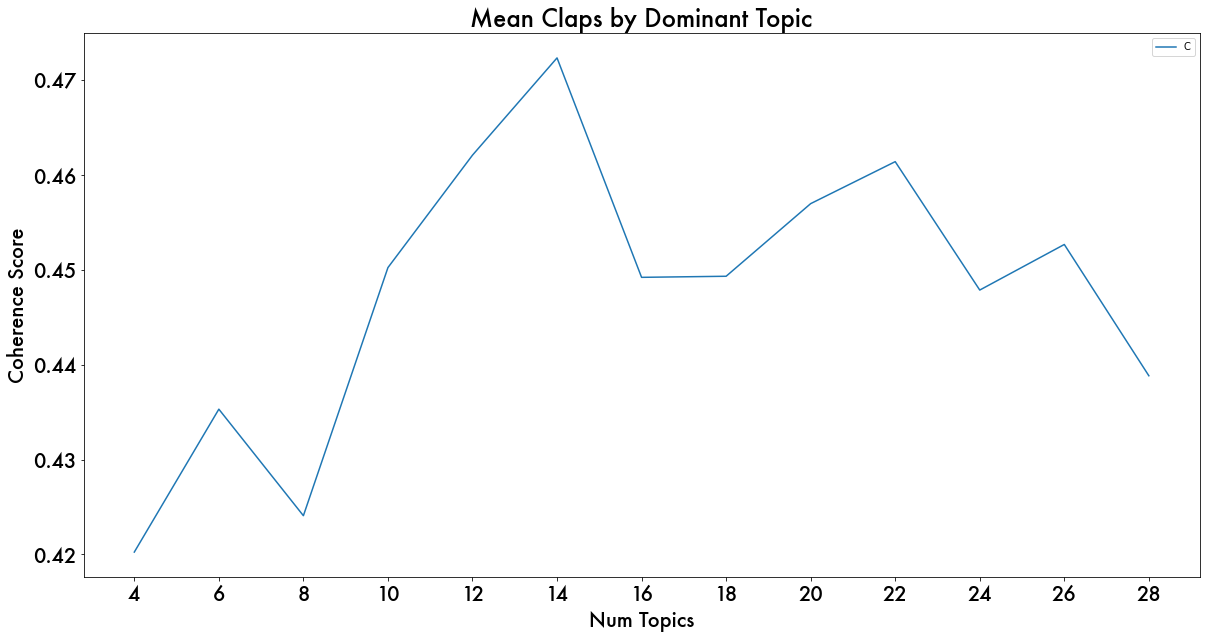

In [36]:
# Show coherence values graph

limit=30; start=4; step=2;
x = range(start, limit, step)
plt.figure(figsize = (20, 10));
sns.lineplot(x=x, y=coherence_values);
figurefont = {'fontname' : 'Futura'};
plt.title('Mean Claps by Dominant Topic', fontsize = 24,**figurefont );
plt.xticks(ticks=range(4,30,2), **figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Num Topics',**figurefont, fontsize = 20);
plt.ylabel('Coherence Score',**figurefont, fontsize = 20);
plt.legend('Coherence Values', loc='best')

plt.savefig('../figures/pubmed_coherence_trigrams.jpg',  bbox_inches = "tight")

The coherence value peaks at 14 topics.

### Create & Visualize Model with Optimal Number of Topics

In [43]:
optimal_model = joblib.load('stored_models/optimal_ldamallet_model_tri.pkl')

#### LDA Mallet Model: 14 Topics

In [44]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.47234944948263774


In [45]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(optimal_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/pubmed_optimal_LDA_mallet_model14_tri.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.195559 -0.147586       1        1  6.939019
1     -0.175041  0.234637       2        1  7.416531
2     -0.081479 -0.070090       3        1  7.251646
3      0.090392 -0.109254       4        1  7.785603
4     -0.020113  0.122397       5        1  7.243080
5     -0.151374 -0.183406       6        1  7.278296
6      0.144939 -0.132093       7        1  7.020824
7      0.101945  0.281079       8        1  7.640943
8     -0.057594  0.185447       9        1  7.118086
9      0.084775 -0.089442      10        1  6.867513
10     0.209065  0.000668      11        1  6.735102
11     0.226736 -0.048516      12        1  6.748174
12     0.043293  0.003964      13        1  6.725094
13    -0.219984 -0.047804      14        1  7.230088, topic_info=         Term         Freq        Total Category  logprob  loglift
30       data  4411.000000  4411.000000  Default  30.0000  30.0000
70    machine  4293.000000  4293.000000  Default  29.0000  29.0000
200  learning  3011.000000  3011.000000  Default  28.0000  28.0000
354     model  2358.000000  2358.000000  Default  27.0000  27.0000
67      learn  2395.000000  2395.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
46      focus   276.735715   725.926475  Topic14  -4.4347   1.6625
90    provide   340.197667  1623.054346  Topic14  -4.2283   1.0644
479     offer   170.619008   288.309469  Topic14  -4.9184   2.1023
252      make   186.224398   458.708025  Topic14  -4.8309   1.7255
70    machine   241.363475  4293.708472  Topic14  -4.5715  -0.2517

[1151 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
397       2  0.396812   ability
397       6  0.604489   ability
1551      8  1.008129   absence
2981      4  0.997267  abstract
920       9  0.936767     abuse
...     ...       ...       ...
1765      5  0.146912  workflow
595       1  0.288451      year
595      11  0.085467      year
595      14  0.626757      year
1945      6  0.969014   βstrand

[1625 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

Decent distribution across the space; a bit more overlap than I'd like. I will examine 12 topics too; only slightly lower coherence score. .

#### LDA Mallet Model: 12 Topics

In [46]:
optimal_model = joblib.load('stored_models/ldamallet_model12_tri.pkl')

In [47]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.46209561685325323


In [48]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(optimal_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/pubmed_optimal_LDA_mallet_model12_tri.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.101911 -0.211024       1        1  8.295890
1      0.072249  0.088555       2        1  8.828170
2      0.214645 -0.141265       3        1  8.244008
3     -0.102919 -0.077014       4        1  8.438058
4     -0.103600 -0.075272       5        1  8.056278
5      0.158113 -0.223561       6        1  8.285002
6     -0.226528 -0.028523       7        1  8.207073
7      0.033837  0.234014       8        1  8.716164
8      0.050817  0.243203       9        1  8.135839
9     -0.254227  0.080468      10        1  8.536116
10     0.221873  0.062985      11        1  8.105974
11     0.037652  0.047434      12        1  8.151428, topic_info=          Term         Freq        Total Category  logprob  loglift
30        data  4420.000000  4420.000000  Default  30.0000  30.0000
70     machine  4301.000000  4301.000000  Default  29.0000  29.0000
200   learning  3015.000000  3015.000000  Default  28.0000  28.0000
354      model  2272.000000  2272.000000  Default  27.0000  27.0000
107      study  2505.000000  2505.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
228  structure   152.756591   446.599594  Topic12  -5.1489   1.4342
126   describe   152.756591   500.855729  Topic12  -5.1489   1.3195
459       type   149.574160   500.880778  Topic12  -5.1700   1.2984
248   function   144.270112   486.202793  Topic12  -5.2061   1.2920
60     include   159.121441  1437.892300  Topic12  -5.1081   0.3057

[989 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
397       6  0.272446   ability
397       9  0.170733   ability
397      10  0.559423   ability
2981      8  1.000993  abstract
920       8  0.939393     abuse
...     ...       ...       ...
2035      1  1.019879    worker
1765      1  0.998231  workflow
643       6  0.974868     world
643       7  0.027853     world
2740      8  0.939393  yearbook

[1366 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

Still a fair amount oof overlapping topics. Let's see if we can improve by dropping to 10 topics. 

#### LDA Mallet Model: 10 Topics

In [49]:
optimal_model = joblib.load('stored_models/ldamallet_model10_tri.pkl')

In [50]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.45024274905377776


In [51]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(optimal_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/pubmed_optimal_LDA_mallet_model10_tri.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.040625 -0.100771       1        1   9.752523
1     -0.150092  0.251695       2        1  10.390215
2      0.069413 -0.093883       3        1   9.837759
3      0.045411  0.083061       4        1   9.743433
4     -0.250734  0.067161       5        1   9.704303
5      0.271206 -0.038782       6        1   9.866866
6      0.050477 -0.222417       7        1  10.688752
7     -0.232575 -0.222324       8        1   9.877782
8      0.193304  0.074394       9        1   9.933472
9      0.044214  0.201866      10        1  10.204894, topic_info=            Term         Freq        Total Category  logprob  loglift
30          data  4421.000000  4421.000000  Default  30.0000  30.0000
70       machine  4378.000000  4378.000000  Default  29.0000  29.0000
354        model  2326.000000  2326.000000  Default  28.0000  28.0000
200     learning  3072.000000  3072.000000  Default  27.0000  27.0000
107        study  2485.000000  2485.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
2    application   211.083402  2105.154251  Topic10  -5.0502  -0.0176
60       include   201.678689  1429.298122  Topic10  -5.0958   0.3240
447      require   178.689409   477.640595  Topic10  -5.2168   1.2991
923         area   172.419606   522.251018  Topic10  -5.2525   1.1741
50        future   172.419606  1184.335900  Topic10  -5.2525   0.3553

[831 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
397       2  0.345947    ability
397       6  0.651836    ability
1447      9  0.995880   abnormal
2981      7  0.996259   abstract
920      10  0.956968      abuse
...     ...       ...        ...
463       7  0.357735       work
2035      2  1.031788     worker
1765      2  0.997720   workflow
1052      4  0.011926  worldwide
1052      5  0.989886  worldwide

[1157 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

Sacrificing only 2% coherence score in order to have entirely non-overlapping topics feels like the right move. 

### Find the Dominant Topic in Each Document

In [52]:
pd.set_option('max_colwidth', 100)

In [53]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

def format_topics_docs(ldamodel, corpus=corpus, texts=data_words_trigrams):
    # Init output
    docs_topics_df = pd.DataFrame()
 
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                docs_topics_df = docs_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]),ignore_index=True)
            else:
                break
    docs_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    docs_topics_df = pd.concat([docs_topics_df, contents], axis=1)
    return(docs_topics_df)

In [54]:
df_topic_docs_keywords = format_topics_docs(ldamodel=converted_model, corpus=corpus, texts=data_words_trigrams)

df_dominant_topic=pd.DataFrame()
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#reset index to pmid numbers
df_dominant_topic.index = df.index


In [55]:
# show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
pmid,,,,,
22627698,0,4.0,0.1597,"disease, clinical, treatment, patient, cancer, biomarker, diagnostic, diagnosis, response, improve","[extract, biological, information, computational, analysis, infrared, ftir, biospectroscopy, dat..."
22952238,1,0.0,0.3309,"approach, cell, genetic, mechanism, biological, genomic, analysis, gene, tool, biology","[uncover, transcription, factor, module, analyse, transcriptional, regulation, critical, mediato..."
22944687,2,2.0,0.4096,"prediction, method, computational, drug, protein, design, approach, predict, structure, target","[understand, substrate, specificity, conventional, calpain, calpain, intracellular, dependent, c..."
22075226,3,2.0,0.4112,"prediction, method, computational, drug, protein, design, approach, predict, structure, target","[membrane, protein, structural, bioinformatics, increase, number, recently, solve, membrane, pro..."
23012584,4,1.0,0.2195,"artificial_intelligence, ai, technology, clinical, health, care, application, improve, patient, ...","[future, medical, diagnostic, large, digitized, database, electronic_health_record, mandate, ame..."


#### Find the most representative document for each topic

In [56]:
doc_topics_sorteddf_mallet = pd.DataFrame()


#reset index to pmid numbers
df_topic_docs_keywords.index = df.index

doc_topics_outdf_grpd = df_topic_docs_keywords.groupby('Dominant_Topic')

for i, grp in doc_topics_outdf_grpd:
    doc_topics_sorteddf_mallet = pd.concat([doc_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Format
doc_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]


In [57]:
# Show topics and keywords
doc_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
pmid,,,,
26941766,0.0,0.5472,"approach, cell, genetic, mechanism, biological, genomic, analysis, gene, tool, biology","[change, game, integrative, genomics, probe, virulence, mechanism, stem, rust, pathogen, puccini..."
32528777,1.0,0.4941,"artificial_intelligence, ai, technology, clinical, health, care, application, improve, patient, ...","[artificial_intelligence, modern, medicine, evolve, necessity, present, role, transform, future,..."
30338736,2.0,0.5428,"prediction, method, computational, drug, protein, design, approach, predict, structure, target","[survey, machine, learning, technique, prediction, isoform, specificity, cytochrome, substrate, ..."
32605178,3.0,0.5031,"system, review, challenge, sensor, human, signal, provide, device, work, material","[survey, iot, security, base, layered, architecture, sensing, data, analysis, internet, thing, l..."
32192349,4.0,0.4555,"disease, clinical, treatment, patient, cancer, biomarker, diagnostic, diagnosis, response, improve","[biomarker, neoadjuvant, adjuvant, chemotherapy, breast_cancer, improvement, tumor, biomarker, p..."
30654138,5.0,0.5290,"machine, model, learning, learn, approach, method, apply, network, dataset, application","[extensive, experimental, survey, regression, method, regression, relevant, problem, machine, le..."
32607629,6.0,0.5221,"study, review, result, method, literature, algorithm, paper, article, performance, search","[machine, learning, identification, clinically, significant, prostate_cancer, mri, metaanalysis,..."
33173516,7.0,0.5313,"study, risk, brain, individual, disorder, assessment, review, outcome, finding, measure","[selective, review, neuroimaging, finding, youth, clinical, high, risk, psychosis, path, biomark..."
31199919,8.0,0.5082,"image, deep, imaging, technique, learning, analysis, machine, application, review, learn","[pathology, image, analysis, segmentation, deep, learning, algorithm, rapid, development, image,..."


#### Explore Relationship Between Dominant Topic and Number of Citations

In [58]:
df.head()

,text,citations
pmid,,
22627698,extracting biological information with computational analysis of fouriertransform infrared (ftir...,35
22952238,uncovering transcription factor modules using one and threedimensional analyses transcriptional ...,4
22944687,understanding the substrate specificity of conventional calpains calpains are intracellular ca(2...,19
22075226,membrane protein structural bioinformatics despite the increasing number of recently solved memb...,12
23012584,the future of medical diagnostics: large digitized databases the electronic health record mandat...,10


In [59]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
pmid,,,,,
22627698,0,4.0,0.1597,"disease, clinical, treatment, patient, cancer, biomarker, diagnostic, diagnosis, response, improve","[extract, biological, information, computational, analysis, infrared, ftir, biospectroscopy, dat..."
22952238,1,0.0,0.3309,"approach, cell, genetic, mechanism, biological, genomic, analysis, gene, tool, biology","[uncover, transcription, factor, module, analyse, transcriptional, regulation, critical, mediato..."
22944687,2,2.0,0.4096,"prediction, method, computational, drug, protein, design, approach, predict, structure, target","[understand, substrate, specificity, conventional, calpain, calpain, intracellular, dependent, c..."
22075226,3,2.0,0.4112,"prediction, method, computational, drug, protein, design, approach, predict, structure, target","[membrane, protein, structural, bioinformatics, increase, number, recently, solve, membrane, pro..."
23012584,4,1.0,0.2195,"artificial_intelligence, ai, technology, clinical, health, care, application, improve, patient, ...","[future, medical, diagnostic, large, digitized, database, electronic_health_record, mandate, ame..."


In [60]:
#merge on index
combined_df = pd.merge(df,df_dominant_topic, how='inner', left_index=True, right_index=True)

In [61]:
combined_df.columns

Index(['text', 'citations', 'Document_No', 'Dominant_Topic',
       'Topic_Perc_Contrib', 'Keywords', 'Text'],
      dtype='object')

In [62]:
combined_df.drop(columns = ['Document_No', 'Text'], inplace=True)


In [63]:
combined_df.head()

,text,citations,Dominant_Topic,Topic_Perc_Contrib,Keywords
pmid,,,,,
22627698,extracting biological information with computational analysis of fouriertransform infrared (ftir...,35,4.0,0.1597,"disease, clinical, treatment, patient, cancer, biomarker, diagnostic, diagnosis, response, improve"
22952238,uncovering transcription factor modules using one and threedimensional analyses transcriptional ...,4,0.0,0.3309,"approach, cell, genetic, mechanism, biological, genomic, analysis, gene, tool, biology"
22944687,understanding the substrate specificity of conventional calpains calpains are intracellular ca(2...,19,2.0,0.4096,"prediction, method, computational, drug, protein, design, approach, predict, structure, target"
22075226,membrane protein structural bioinformatics despite the increasing number of recently solved memb...,12,2.0,0.4112,"prediction, method, computational, drug, protein, design, approach, predict, structure, target"
23012584,the future of medical diagnostics: large digitized databases the electronic health record mandat...,10,1.0,0.2195,"artificial_intelligence, ai, technology, clinical, health, care, application, improve, patient, ..."


In [64]:
#the topics are not ordinal, so I will convert them to strings

combined_df['Dominant_Topic'] = combined_df['Dominant_Topic'].apply(lambda x: str(x).strip('.0').zfill(2))


In [65]:
#colum order
new_column_order = combined_df.groupby('Dominant_Topic')['citations'].mean().sort_values().index

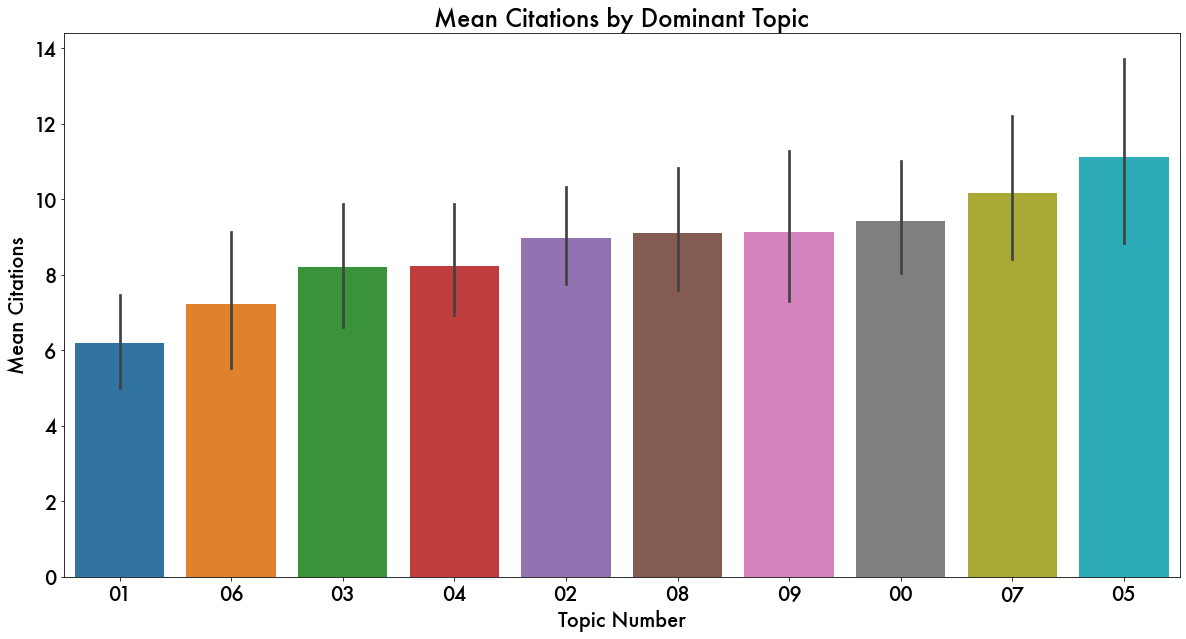

In [66]:
plt.figure(figsize = (20, 10));
sns.barplot(data=combined_df, x='Dominant_Topic', y='citations', order= new_column_order);
figurefont = {'fontname' : 'Futura'};
plt.title('Mean Citations by Dominant Topic', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Topic Number',**figurefont, fontsize = 20);
plt.ylabel('Mean Citations',**figurefont, fontsize = 20);
plt.savefig('../figures/pubmed_mean_citations_trigram_model12.jpg',  bbox_inches = "tight")

#### Model Citations by Topic

In [67]:
model_df = pd.get_dummies(combined_df,columns=['Dominant_Topic'], drop_first=True)

In [68]:
model_df.columns

Index(['text', 'citations', 'Topic_Perc_Contrib', 'Keywords',
       'Dominant_Topic_01', 'Dominant_Topic_02', 'Dominant_Topic_03',
       'Dominant_Topic_04', 'Dominant_Topic_05', 'Dominant_Topic_06',
       'Dominant_Topic_07', 'Dominant_Topic_08', 'Dominant_Topic_09'],
      dtype='object')

In [69]:
import statsmodels.api as sm

In [70]:
model_df.head()

,text,citations,Topic_Perc_Contrib,Keywords,Dominant_Topic_01,Dominant_Topic_02,Dominant_Topic_03,Dominant_Topic_04,Dominant_Topic_05,Dominant_Topic_06,Dominant_Topic_07,Dominant_Topic_08,Dominant_Topic_09
pmid,,,,,,,,,,,,,
22627698,extracting biological information with computational analysis of fouriertransform infrared (ftir...,35,0.1597,"disease, clinical, treatment, patient, cancer, biomarker, diagnostic, diagnosis, response, improve",0,0,0,1,0,0,0,0,0
22952238,uncovering transcription factor modules using one and threedimensional analyses transcriptional ...,4,0.3309,"approach, cell, genetic, mechanism, biological, genomic, analysis, gene, tool, biology",0,0,0,0,0,0,0,0,0
22944687,understanding the substrate specificity of conventional calpains calpains are intracellular ca(2...,19,0.4096,"prediction, method, computational, drug, protein, design, approach, predict, structure, target",0,1,0,0,0,0,0,0,0
22075226,membrane protein structural bioinformatics despite the increasing number of recently solved memb...,12,0.4112,"prediction, method, computational, drug, protein, design, approach, predict, structure, target",0,1,0,0,0,0,0,0,0
23012584,the future of medical diagnostics: large digitized databases the electronic health record mandat...,10,0.2195,"artificial_intelligence, ai, technology, clinical, health, care, application, improve, patient, ...",1,0,0,0,0,0,0,0,0


In [71]:
X = model_df.drop(columns=['text','citations','Keywords', 'Topic_Perc_Contrib'])
X = sm.add_constant(X, prepend=True)
y = model_df['citations']

In [72]:
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              citations   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.742
Date:                Tue, 11 May 2021   Prob (F-statistic):            0.00344
Time:                        15:48:54   Log-Likelihood:                -11421.
No. Observations:                2809   AIC:                         2.286e+04
Df Residuals:                    2799   BIC:                         2.292e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 9.4172      0.769     12.247      0.000       7.909      10.925
Dominant_Topic_01    -3.2145      1.064     -3.022      0.003      -5.300      -1.129
Dominant_Topic_02    -0.4450      1.071     -0.415      0.678      -2.546       1.656
Dominant_Topic_03    -1.2156      1.162     -1.046      0.296      -3.495       1.064
Dominant_Topic_04    -1.1773      1.185     -0.994      0.320      -3.500       1.146
Dominant_Topic_05     1.7042      1.250      1.364      0.173      -0.746       4.154
Dominant_Topic_06    -2.1928      1.251     -1.752      0.080      -4.647       0.261
Dominant_Topic_07     0.7527      1.167      0.645      0.519      -1.536       3.042
Dominant_Topic_08    -0.3174      1.077     -0.295      0.768      -2.430       1.795
Dominant_Topic_09    -0.2945      1.239     -0.238      0.812      -2.723       2.134
==============================================================================
Omnibus:                     1947.185   Durbin-Watson:                   1.639
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24207.483
Skew:                           3.249   Prob(JB):                         0.00
Kurtosis:                      15.830   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

These topics account for very little of the variance in the number of citations. 